### Rodrigo González Linares

# Visual search

## Introduction

Visual search is the process of searching by image, instead of the more traditional text, queries.  

Here we will use this type of search to retrieve similar image to the query and asses if two images are of the same or different class. In particular, we are going to use a subset of the Oxford flowers 102 dataset. This dataset contains images of distinct 102 classes of flowers. The subset in question contains images of 24 species.  

To perform the aforementioned tasks we will first need to train an embedding, that is, a compact space in which images are mapped. Once trained, an embedding should be meaningful, as the mapping of similar images would generally cluster together in such space, while that of dissimilar ones would tend to be far apart.

## Data processing

Firstly, we must import `visualSearch.py`, which contains functions to train the models, visualize embeddings, evaluate their performances, and both obtain images similar to a query image, and asses if two images are of the same class.  
We will also import all other modules we will need along the way.

In [2]:
from visualSearch import *

import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from pytorch_metric_learning.utils import common_functions as c_f
import torchvision.models as models
import torch.nn as nn
from pytorch_metric_learning import miners

Next we will check which type of device is available. I am running the code using an apple silicon Mac, so for me it would be MPS. 

In [3]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")

Code runs in mps


Next we will process the images in the dataset. They are of different sizes, so we will resize them to be 224x224, cropping so that the center of the images is preserved. We will do this for each set; train, validation, and test.
Also, because we are going to train using a ResNet network, we apply a color transformation; the same it was used to train the original ResNet.  
Because when a user queries an image, we do not want to show images transformed with the color normalization, we will also construct train and a test sets identical in every way, but the application of such normalization.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

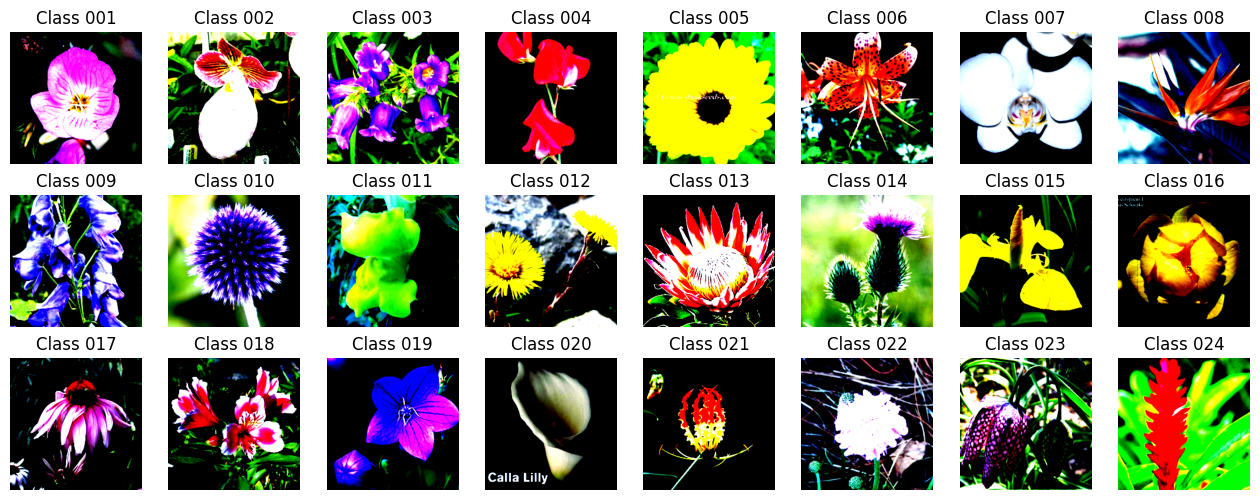

In [9]:
def show_samples(dataset):

    labels_to_indices = c_f.get_labels_to_indices(dataset.targets)
    indexes = [labels_to_indices[i] for i in np.arange(0,24)]

    cols, rows = 8, 3
    figure = plt.figure(figsize=(cols*2, rows*2))

    for i in range(0, cols * rows):
        sample, label = dataset[indexes[i][0]]
        figure.add_subplot(rows, cols, i+1)
        plt.title(f'Class {dataset.classes[label]}')
        plt.axis("off")
        plt.imshow(sample.permute(1, 2, 0), cmap="gray")
    plt.show()

transform = transforms.Compose([
transforms.Resize(224),
transforms.CenterCrop((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Same normalization as ResNet training set 
]) 
       
dataset_train = datasets.ImageFolder(root='./resources/dataset/train', transform=transform)
dataset_valid = datasets.ImageFolder(root='./resources/dataset/valid', transform=transform)
dataset_test = datasets.ImageFolder(root='./resources/dataset/test', transform=transform)
    
# Display labels and samples
show_samples(dataset_train)

# Avoid last transform for images that are actually going to be shown to the user
transform_show = transforms.Compose([
transforms.Resize(224),
transforms.CenterCrop((224, 224)),
transforms.ToTensor()
])

dataset_train_show = datasets.ImageFolder(root='./resources/dataset/train', transform=transform_show)
dataset_test_show = datasets.ImageFolder(root='./resources/dataset/test', transform=transform_show)

## ResNet50 fine-tuning and embedding training using cross-entropy loss

We will next load a pre-trained ResNet50 network. This network contains 50 convolutional layers, separated in four blocks, and includes residual connections. It was trained on imageNet to classify an image into 1 of 1,000 classes, including objects and animal.   

To train an embedding using this network, we will freeze all the parameters but the last two blocks, and then replace the last fully connected layer with an embedding layer and a classification layer.  
The rationale for unfreezing the last two blocks is that, although the pre-trained ResNet was trained on a very similar task, we need to adjust the parameters of the last convolutional layers, which deal with the most low level features, to effectively discern distinct flower types.  
Both the embedding and classification layers are implemented as linear layers in PyTorch. We define the former to have 16 neurons (to correspond with an embedding of dimension 16), while the latter needs to have the same number of neurons as there are classes (i.e. 24).  
The layer we really care about is the embedding one, however, to train using cross-entropy, we need to add the classification layer. After training, when the classification becomes accurate enough, we would ideally obtain an embedding in which data points corresponding to the same class cluster together, while those of different class are far apart in space. 
As we are fine-tuning, we keep both the batch size and learning rates small.  
When done, we will have killed two birds with one stone; we will have a fine-tuned network and a trained embedding. 

In [ ]:
# Load pre-trained model
model = models.resnet50(pretrained=True)

# Freeze the whole network
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze the last two convolutional blocks (layers 3 and 4)
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# Obtain the number of features
num_features = model.fc.in_features
# Obtain good embedding size using heuristic 
embedding_size = 16 
# Define number of classes
num_classes = 24

# Replace last layer of the model by embedding and output layers
model.fc = nn.Sequential(nn.Linear(num_features, embedding_size), # Embedding layer
                         nn.ReLU(),
                         nn.Linear(embedding_size, num_classes),
                         nn.Softmax(dim=1)) 

# Send model to device
model.to(device)

# Set hyperparameters
BATCH_SIZE = 4
LR = 5e-5 
EPOCHS = 300

# Define loss function
corssentropy_loss = nn.CrossEntropyLoss() 
# Define optimizer 
adam_optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Fine-tune model and train the embedding
train_model(model,dataset_train,dataset_valid,device,adam_optimizer,corssentropy_loss,BATCH_SIZE,
            EPOCHS,output_filename='finetuned-resnet.pt')

The best run, which used the same hyperparameters as above, took about 180 epochs to train (before training was halted due to overfitting by the early-stopping mechanism implemented in the training loop), and was saved as `finetuned-resnet-final.pt`.  
We will then load this model, get rid of the classification layer, create train and test dataloaders, and pass them to the `create_embedding_space_and_test` function. This function passes the images through the network and obtains their corresponding points in embedding space.

In [4]:
# Load the trained model
model = torch.load('finetuned-resnet-final.pt') 

# For inference set device to cpu (MPS was causing problems)
device = torch.device("cpu")
model.to(device)

# Clone the embedding weights and biases
embedding_weights = model.fc[0].weight.data.clone()
embedding_biases = model.fc[0].bias.data.clone()

# Define the number of features (the number was obtained before fine-tunning and was 2048)
num_features = 2048
# Recover embedding size
embedding_size = 16
# Modify the last layer to contain only the embedding layer
model.fc = nn.Linear(num_features, embedding_size)

# Update the embedding weights and biases to correspond to the obtained ones during training 
model.fc.weight.data = embedding_weights
model.fc.bias.data = embedding_biases

# Construct train and test loaders
train_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=1)

# Obtain the points in the embedding space, their corresponding labels, and the points for the test set
embedding_space, labels, embedding_test = create_embedding_space_and_test(train_loader,test_loader,model)

Once that is done we can visualize this embedding space by performing a PCA, showing the first two principal components.

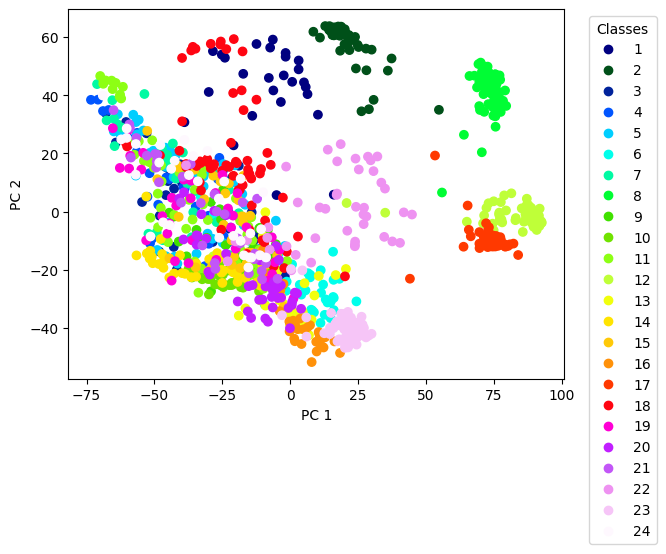

In [5]:
# Visualize the embedding space using a 2-D PCA plot
create_embeding_PCA(embedding_space,labels) 

We can see some classes like 2, 11, 12, and 17 were able to separate really well; while others like 20 and 14 are all over the place, and at least when plotting the first two principal components, completely overlap with other classes. We would therefore expect the former classes to yield good results and the former poorer ones.  

We will evaluate the efficiency of the embedding by calculating a metric popular for recommendation systems called mean average precision at k (mAP@k), where k is the is the number of nearest neighbors to the data sample to be evaluated. When one of the nearest neighbors is of the same class as the data sample of interest, the value of the metric will go up. The metric also assigns more value the nearer the neighbor is to such data sample.  
The closer the mAP@k is to 0, the worst the performance of the embedding, and the closer to 1, the best.   

We will calculate the mAP@k taking into account each sample in the test set, and we will repeat this for different k numbers. We will not calculate the average of these results as an average mean average precision would just be too much. 

In [6]:
ks = [1,3,5,7,11]

for k in ks:
    mAP_k = evaluate_embedding(k,embedding_test,embedding_space,test_loader,train_loader)
    print(f'mAP@{k}: {mAP_k}')

mAP@1: 0.5357142857142857
mAP@3: 0.569940476190476
mAP@5: 0.567063492063492
mAP@7: 0.5630881519274376
mAP@11: 0.5562866969930107


Next, we will perform some searches of images similar (as judge by the embedding) to a query image. 

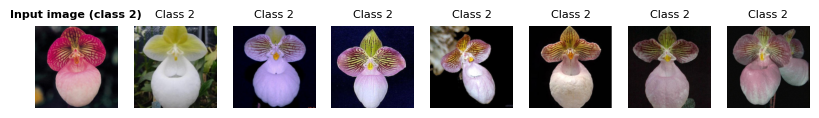

The mAP@k is 1.0


In [7]:
# Load unnormalized images to be show to the users
train_loader_show = DataLoader(dataset_train_show, batch_size=1)
test_loader_show = DataLoader(dataset_test_show, batch_size=1)

# Define the index of an image in the test set to find the most similar images in the train set
image_index = 4
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

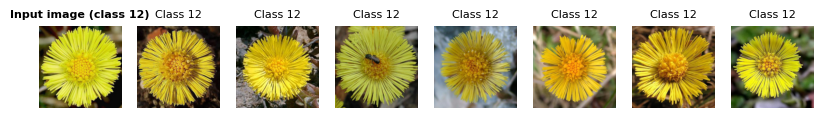

The mAP@k is 1.0


In [8]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 25
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

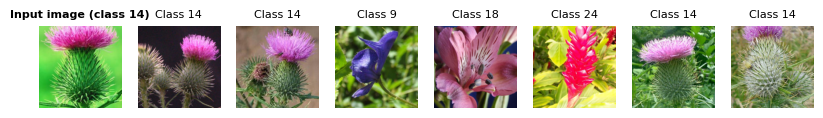

The mAP@k is 0.7678571428571428


In [9]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 30
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

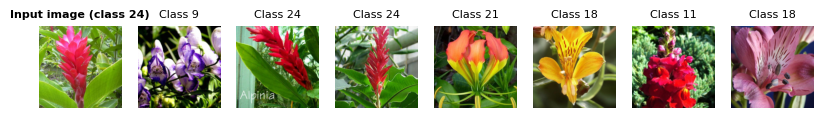

The mAP@k is 0.5833333333333333


In [10]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 55
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

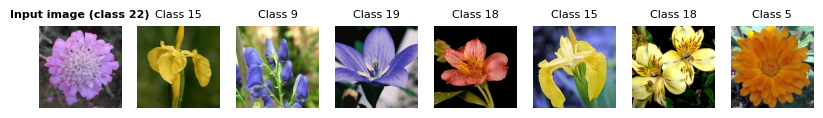

The mAP@k is 0


In [11]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 50
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

As it can be seen on the searches, the embedding manages to do a perfect job, while on others a decent enough one, and terrible in a few. In general, it seems to have problems with more generic looking flowers.  

Now we will try a different task, in which we input a couple of images and judge if they are of the same or a different class. 

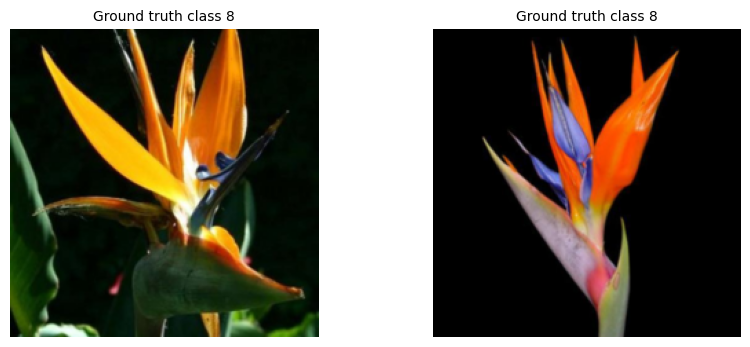

Both images are predicted to be of class 8!


In [12]:
# Define the indices of a couple of images in the test set to evaluate if they belong to the same class or not
image1_index = 15
image2_index = 16 
# Define the number of neighbors in the train set to perform the evaluation
n_neighbors = 7

# Make the predictions
predict_classes(image1_index,image2_index,n_neighbors,embedding_test,embedding_space,
                test_loader_show,train_loader_show)

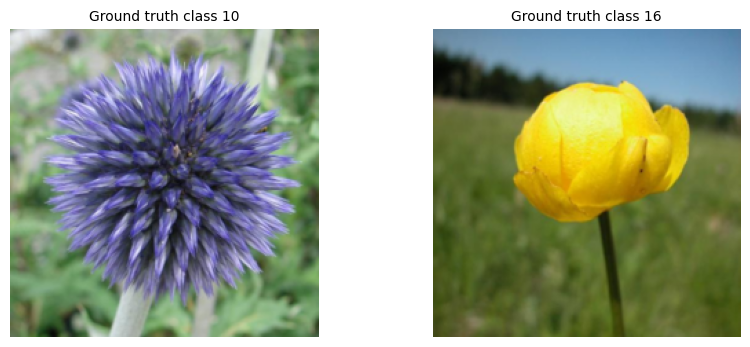

Images are predicted to be of different classes!
The first image is predicted to be of class 10 and the second of class 16


In [13]:
# Define the indices of a couple of images in the test set to evaluate if they belong to the same class or not
image1_index = 20
image2_index = 35 
# Define the number of neighbors in the train set to perform the evaluation
n_neighbors = 7

# Make the predictions
predict_classes(image1_index,image2_index,n_neighbors,embedding_test,embedding_space,
                test_loader_show,train_loader_show)

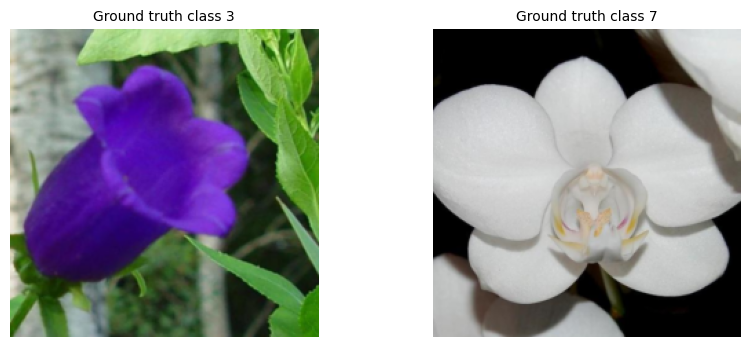

Images are predicted to be of different classes!
The first image is predicted to be of class 20 and the second of class 18


In [14]:
# Define the indices of a couple of images in the test set to evaluate if they belong to the same class or not
image1_index = 6
image2_index = 13 
# Define the number of neighbors in the train set to perform the evaluation
n_neighbors = 7

# Make the predictions
predict_classes(image1_index,image2_index,n_neighbors,embedding_test,embedding_space,
                test_loader_show,train_loader_show)

All of this test yielded the correct results, although only the first two for the correct reasons, as the predictions for all images corresponded to the ground truth. On the last test however, the classes were misassigned. 

## Training an embedding using triplet loss, and a fine-tunned ResNet50

Next, we will resort to a different approach. Before we added that final classification layer, but it is also possible to have the embedding as the last layer during training; however, we need to use a different loss function to implement such approach. A couple of popular options are the contrastive and triplet losses.  
Contrastive loss aims at minimizing the distance between similar samples and maximizing the distant between dissimilar samples. This is done by pairing each training sample with either another positive sample (from the same class) or a negative sample (from a different class).  
Triplet loss serves to fulfill the same objective, but operates on triplets of samples: an anchor sample, a positive sample, and a negative sample. Here, the anchor is the sample for which we want to adjust its embedding representation; as such the positive sample belongs to the same class, while the negative belongs to a different class. Therefore the function aims to minimize the distances between anchors and positive samples, and maximize the distances between anchors and negative samples.  

Related to this is the concept of miners. Miners are the functions that actually create the pairs or triplets to calculate the losses; and there exist two broad types, online and offline miners.  
Online miners perform the selection during each epoch within the data samples of each batch, while offline miners do the selection before the training loop for the whole dataset. Offline miners tend be computationally significantly more expensive than online ones, so we are going to stick with the latter.
By default the `train_with_miner` function uses the contrastive loss and the pair margin miner, but other other losses and miners can be used. In fact better results were obtained using the triplet loss and the triplet margin miner, and therefore they are included in the code below.  

Regarding sampling we are going to stick with random sampling as before (the default for `DataLoader`), but this time we will construct larger batches of size 128, so that the miners have more data samples to select appropriate pairs or triplets once during training.  

We will also take advantage of the fact we already obtained a fine tuned network for the problem at hand, and train a new embedding using the fined-tuned network previously obtained. To do this we will replace the prior embedding and classifier with a new untrained embedding, while keeping the rest of the layers frozen. As we are not fine-tunning any more, we will use a larger learning rate this time.

In [ ]:
# Load pre-trained model
model = torch.load('tripletLoss-resnet.pt') 

# Freeze the whole network
for param in model.parameters():
    param.requires_grad = False

# Obtain the number of features
num_features = model.fc[0].in_features
# Obtain good embedding size using heuristic 
embedding_size = 16 

# Modify the last layer to contain only the embedding layer
model.fc = nn.Linear(num_features, embedding_size)

# Send model to cpu (MPS was causing problems)
device = torch.device("cpu")
model.to(device)

# Hyperparameters
BATCH_SIZE = 128
LR = 4e-4 
EPOCHS = 300

# Define optimizer
adam_optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Define the miner and loss functions
miner=miners.TripletMarginMiner()
loss=losses.TripletMarginLoss()

# Fine-tune model and train the embedding
# By default the training is done using contrastative loss and a pair margin miner
train_with_miner(model,dataset_train,dataset_valid,device,adam_optimizer,batch_size=BATCH_SIZE,
                 num_epochs=EPOCHS,output_filename='tripletLoss-resnet.pt',miner=miner,loss=loss)

The best run was achieved using the above hyperparameters over a few epochs. The resulting network was saved as `tripletLoss-resnet-final.pt`.

In [15]:
# Load the trained model
model = torch.load('tripletLoss-resnet-final.pt') 

# For inference set device to cpu (MPS was causing problems)
device = torch.device("cpu")
model.to(device)

# Construct train and test loaders
train_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=1)

# Obtain the points in the embedding space, their corresponding labels, and the points for the test set
embedding_space, labels, embedding_test = create_embedding_space_and_test(train_loader,test_loader,model)

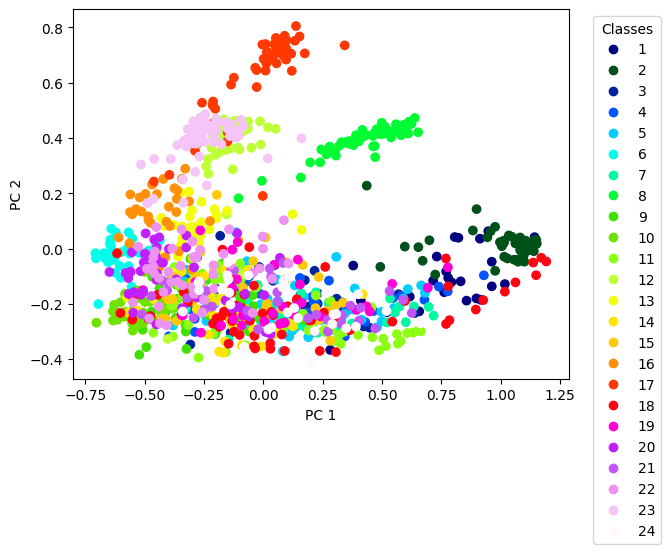

In [16]:
# Visualize the embedding space using a 2-D PCA plot
create_embeding_PCA(embedding_space,labels) 

The results are somewhat similar, suggesting that some aspect of the architecture (e.g. number of convolutional layers, embedding dimension, etc.) or the dataset themselves (e.g. few samples) might be the limiting factor for vastly increasing the separation of classes. Despite this, there seem to be some significant improvements, as overall the classes seem to be more spread out than before. 
There is only one way, however, to asses which embedding performs better...

In [17]:
ks = [1,3,5,7,11]

for k in ks:
    mAP_k = evaluate_embedding(k,embedding_test,embedding_space,test_loader,train_loader)
    print(f'mAP@{k}: {mAP_k}')

mAP@1: 0.5714285714285714
mAP@3: 0.6473214285714285
mAP@5: 0.6493799603174601
mAP@7: 0.6486819727891154
mAP@11: 0.6270358301900607


The results are indeed significantly better.

A before, we will perform some searches.

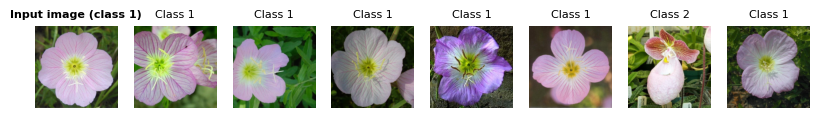

The mAP@k is 0.9761904761904762


In [18]:
# Load unnormalized images to be show to the users
train_loader_show = DataLoader(dataset_train_show, batch_size=1)
test_loader_show = DataLoader(dataset_test_show, batch_size=1)

# Define the index of an image in the test set to find the most similar images in the train set
image_index = 0
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

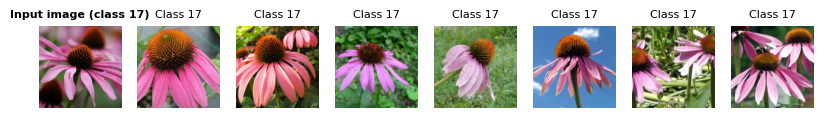

The mAP@k is 1.0


In [19]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 38
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

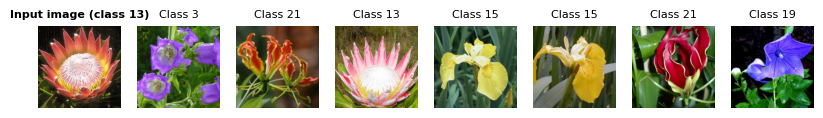

The mAP@k is 0.3333333333333333


In [20]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 28
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

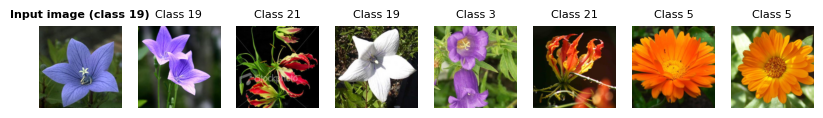

The mAP@k is 0.8333333333333333


In [21]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 43
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

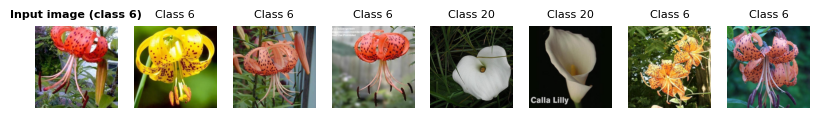

The mAP@k is 0.8761904761904761


In [22]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 11
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

The search works fairly well, and manages to find similar images even for classes that were notoriously difficult to deal with for the last embedding; class 19 for example.

As before, we will compare pairs of images.

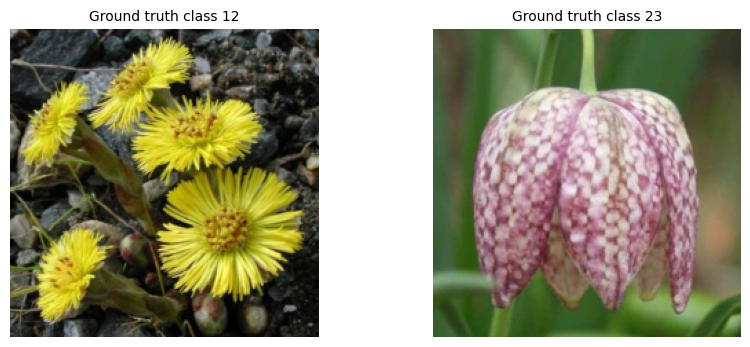

Images are predicted to be of different classes!
The first image is predicted to be of class 12 and the second of class 23


In [23]:
# Define the indices of a couple of images in the test set to evaluate if they belong to the same class or not
image1_index = 23
image2_index = 52
# Define the number of neighbors in the train set to perform the evaluation
n_neighbors = 7

# Make the predictions
predict_classes(image1_index,image2_index,n_neighbors,embedding_test,embedding_space,
                test_loader_show,train_loader_show)

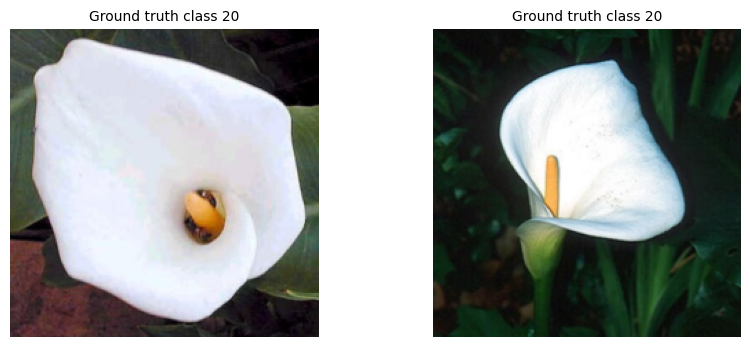

Images are predicted to be of different classes!
The first image is predicted to be of class 19 and the second of class 20


In [28]:
# Define the indices of a couple of images in the test set to evaluate if they belong to the same class or not
image1_index = 46
image2_index = 47
# Define the number of neighbors in the train set to perform the evaluation
n_neighbors = 7

# Make the predictions
predict_classes(image1_index,image2_index,n_neighbors,embedding_test,embedding_space,
                test_loader_show,train_loader_show)

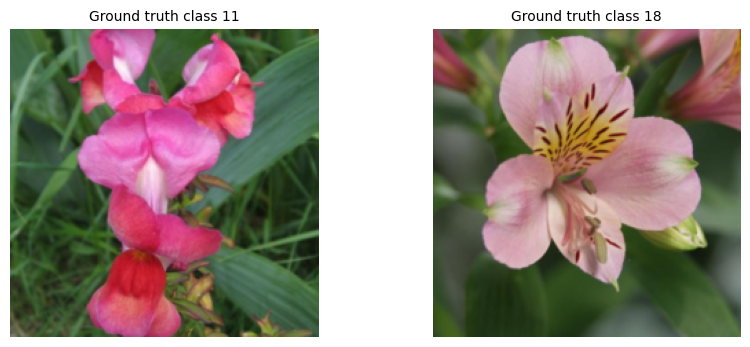

Images are predicted to be of different classes!
The first image is predicted to be of class 15 and the second of class 1


In [25]:
# Define the indices of a couple of images in the test set to evaluate if they belong to the same class or not
image1_index = 22
image2_index = 42
# Define the number of neighbors in the train set to perform the evaluation
n_neighbors = 7

# Make the predictions
predict_classes(image1_index,image2_index,n_neighbors,embedding_test,embedding_space,
                test_loader_show,train_loader_show)

This time the first prediction was correct for the right reasons, the second was wrong, and the third was again right, but this time for the wrong reasons, as one of the flowers was misclassified.  
There is however a silver lining regarding the second prediction. The first embedding had a lot of trouble dealing with images of class 20, but this new version managed to classify one of them correctly.

## Exploring other model: VGG-16

Due to ResNet being a slightly more modern architecture than VGG, the former was considered first. However, the pre-trained VGG-16 does exceptionally well in this scenario right of the bat, without any fine-tunning. As before, layers corresponding to the classifier were replaced for an embedding layer (this time of size 32), and a 24-neuron classification layer. 

In [ ]:
# Load pre-trained model
model = models.vgg16(pretrained=True)

# Freeze the whole network
for param in model.parameters():
    param.requires_grad = False

# Obtain the number of features
num_features = model.classifier[0].in_features
# Obtain good embedding size using heuristic 
embedding_size = 32 
# Define number of classes
num_classes = 24

# Replace last layer of the model by embedding and output layers
model.classifier = nn.Sequential(nn.Linear(num_features, embedding_size), # Embedding layer
                         nn.ReLU(),
                         nn.Linear(embedding_size, num_classes),
                         nn.Softmax(dim=1)) 

# Send model to device
model.to(device)

# Set hyperparameters
BATCH_SIZE = 16
LR = 1e-4 
EPOCHS = 300

# Define loss function
corssentropy_loss = nn.CrossEntropyLoss() 
# Define optimizer 
adam_optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Fine-tune model and train the embedding
train_model(model,dataset_train,dataset_valid,device,adam_optimizer,corssentropy_loss,BATCH_SIZE,
            EPOCHS,output_filename='crossEntropy-vgg.pt')

After around 160 epochs of training, the following embedding, saved as `crossEntropy-vgg-final.pt`, was obtained.

In [5]:
# Load the trained model
model = torch.load('crossEntropy-vgg-final.pt') 

# For inference set device to cpu (MPS was causing problems)
device = torch.device("cpu")
model.to(device)

# Clone the embedding weights and biases
embedding_weights = model.classifier[0].weight.data.clone()
embedding_biases = model.classifier[0].bias.data.clone()

# Define the number of features (the number was obtained before fine-tunning and was 2048)
num_features = 25088
# Recover embedding size
embedding_size = 32
# Modify the last layer to contain only the embedding layer
model.fc = nn.Linear(num_features, embedding_size)

# Update the embedding weights and biases to correspond to the obtained ones during training 
model.fc.weight.data = embedding_weights
model.fc.bias.data = embedding_biases

# Construct train and test loaders
train_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=1)

# Obtain the points in the embedding space, their corresponding labels, and the points for the test set
embedding_space, labels, embedding_test = create_embedding_space_and_test(train_loader,test_loader,model)

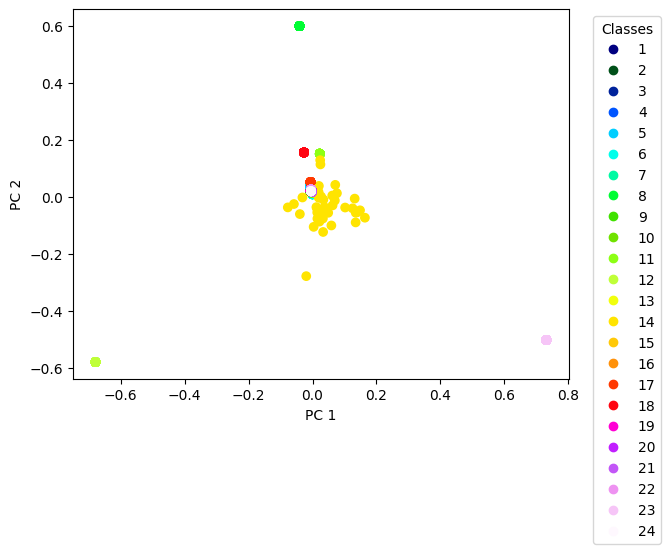

In [6]:
# Visualize the embedding space using a 2-D PCA plot
create_embeding_PCA(embedding_space,labels) 

Taking into account only the two principal component, we can see most classes coalesce together very tightly, suggesting the same is true in the higher-dimensional embedding.  

The plot seems very promising, and we can see the calculation of mAP@k confirms the general quality of the embedding. 

In [7]:
ks = [1,3,5,7,11]

for k in ks:
    mAP_k = evaluate_embedding(k,embedding_test,embedding_space,test_loader,train_loader)
    print(f'mAP@{k}: {mAP_k}')

mAP@1: 0.9464285714285714
mAP@3: 0.9464285714285714
mAP@5: 0.9464285714285714
mAP@7: 0.9464285714285714
mAP@11: 0.9464285714285714


We will now query examples that were specially problematic for the embeddings trained using ResNet50. 

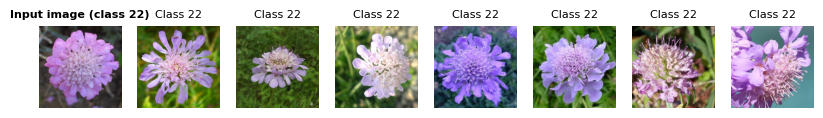

The mAP@k is 1.0


In [11]:
# Load unnormalized images to be show to the users
train_loader_show = DataLoader(dataset_train_show, batch_size=1)
test_loader_show = DataLoader(dataset_test_show, batch_size=1)

# Define the index of an image in the test set to find the most similar images in the train set
image_index = 50
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

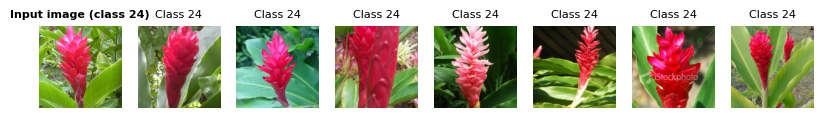

The mAP@k is 1.0


In [12]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 55
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

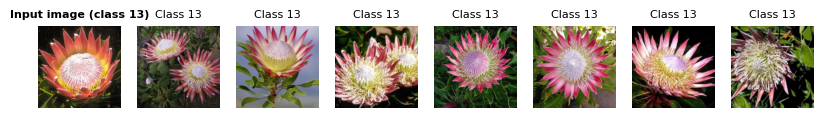

The mAP@k is 1.0


In [13]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 28
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

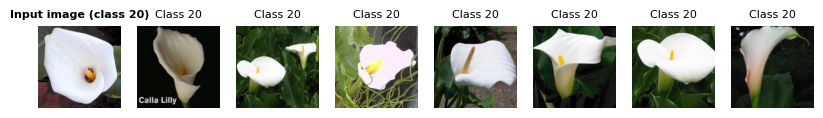

The mAP@k is 1.0


In [23]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 46
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

So far the results have been perfect; however, it does a terrible job for some specific instances.  
For example, querying the following image pertaining to class 19 returns only images corresponding to class 18. 

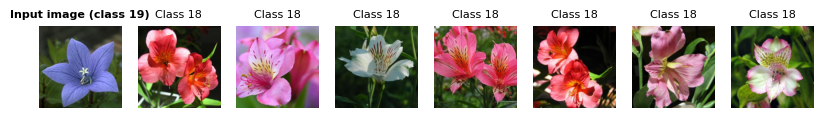

The mAP@k is 0


In [14]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 43
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

For other instances of class 19 however, the embedding does perfectly again.

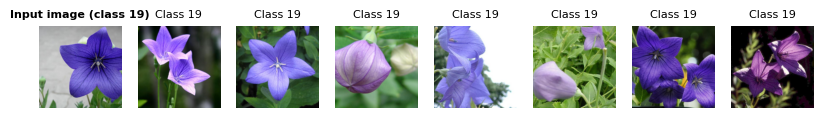

The mAP@k is 1.0


In [18]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 44
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

And just to make sure images of class 18 are not misclassified, we will try a couple of instances.

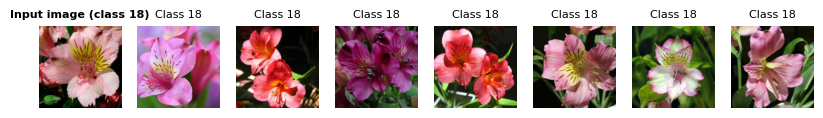

The mAP@k is 1.0


In [21]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 41
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

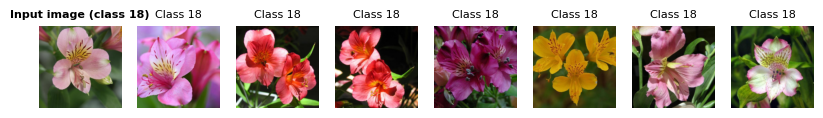

The mAP@k is 1.0


In [17]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 42
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

Finally, we will assess whether the embedding also performs well for the only scattered class on the PCA plot.

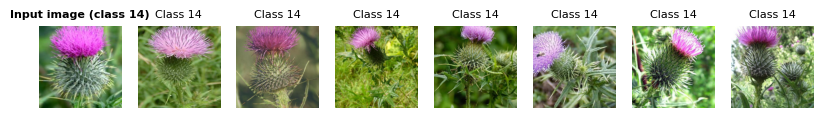

The mAP@k is 1.0


In [22]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 29
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

Now using triplet loss on the VGG-16, overfitting arises only after a couple epochs.

In [ ]:
# Load pre-trained model
model = models.vgg16(pretrained=True)

# Freeze the whole network
for param in model.parameters():
    param.requires_grad = False

# Obtain the number of features
num_features = model.classifier[0].in_features
# Obtain good embedding size using heuristic 
embedding_size = 32 
# Define number of classes
num_classes = 24

# Replace last layer of the model by embedding and output layers
model.classifier = nn.Sequential(nn.Linear(num_features, embedding_size), # Embedding layer
                         nn.ReLU(),
                         nn.Linear(embedding_size, num_classes),
                         nn.Softmax(dim=1)) 

# Send model to cpu (MPS was causing problems)
device = torch.device("cpu")
model.to(device)

# Hyperparameters
BATCH_SIZE = 128
LR = 1e-4 
EPOCHS = 300

# Define optimizer
adam_optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Define the miner and loss functions
miner=miners.TripletMarginMiner()
loss=losses.TripletMarginLoss()

# Fine-tune model and train the embedding
# By default the training is done using contrastative loss and a pair margin miner
train_with_miner(model,dataset_train,dataset_valid,device,adam_optimizer,batch_size=BATCH_SIZE,
                 num_epochs=EPOCHS,output_filename='tripletLoss-vgg.pt',miner=miner,loss=loss)

Despite the quick overfitting we manage to obtain an embedding in which classes are much more spread out compared to the last one, but in which data points corresponding to the same class are still relatively close together.

In [24]:
# Load the trained model
model = torch.load('tripletLoss-vgg-final.pt') 

# For inference set device to cpu (MPS was causing problems)
device = torch.device("cpu")
model.to(device)

# Construct train and test loaders
train_loader = DataLoader(dataset_train, batch_size=1)
test_loader = DataLoader(dataset_test, batch_size=1)

# Obtain the points in the embedding space, their corresponding labels, and the points for the test set
embedding_space, labels, embedding_test = create_embedding_space_and_test(train_loader,test_loader,model)

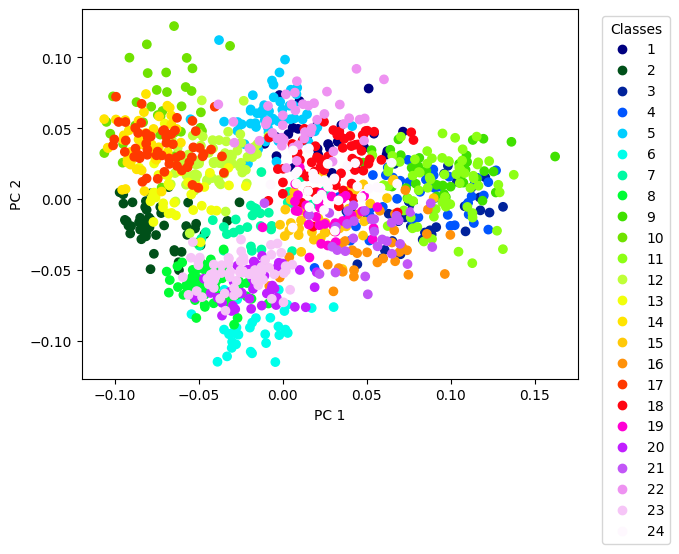

In [25]:
# Visualize the embedding space using a 2-D PCA plot
create_embeding_PCA(embedding_space,labels) 

In [26]:
ks = [1,3,5,7,11]

for k in ks:
    mAP_k = evaluate_embedding(k,embedding_test,embedding_space,test_loader,train_loader)
    print(f'mAP@{k}: {mAP_k}')

mAP@1: 0.75
mAP@3: 0.7857142857142856
mAP@5: 0.786904761904762
mAP@7: 0.7802650226757369
mAP@11: 0.7432920561502622


Although the results are not as good as last time, this information, coupled with the PCA plot, suggests this embedding will perform worst on average, but will almost never perform terribly; in stark contrast with the prior example.  
To see this, we will query some of the same images as before.

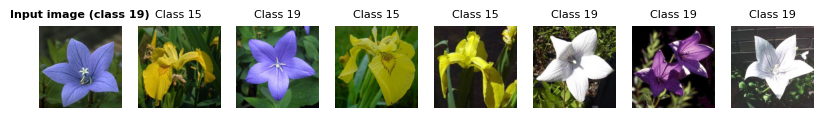

The mAP@k is 0.4928571428571428


In [27]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 43
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

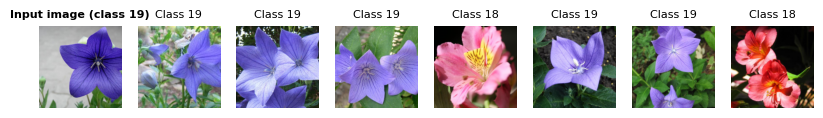

The mAP@k is 0.9266666666666665


In [28]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 44
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

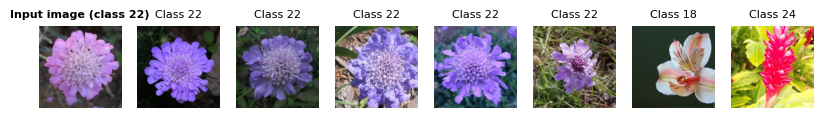

The mAP@k is 1.0


In [30]:
# Load unnormalized images to be show to the users
train_loader_show = DataLoader(dataset_train_show, batch_size=1)
test_loader_show = DataLoader(dataset_test_show, batch_size=1)

# Define the index of an image in the test set to find the most similar images in the train set
image_index = 50
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

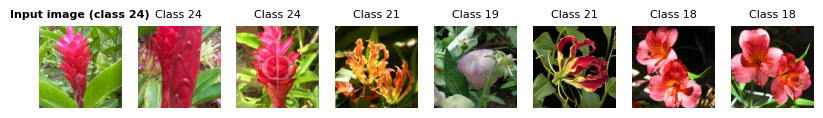

The mAP@k is 1.0


In [31]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 55
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

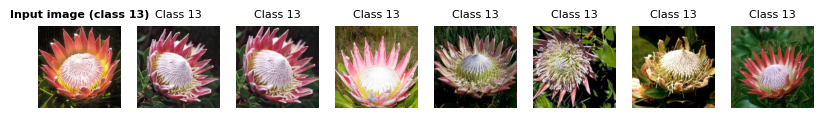

The mAP@k is 1.0


In [29]:
# Define the index of an image in the test set to find the most similar images in the train set
image_index = 28
# Define the number of similar images to find
n_neighbors = 7

# Obtain the most similar images
obtain_k_nearest_neighbors(image_index,n_neighbors,embedding_test,embedding_space,
                           test_loader_show,train_loader_show)

And indeed the suggestions seem to be true.

## Conclusions 

Regarding ResNet50 in general the results are fairly good, although a few classes seem to be very problematic to separate in embedding space. Training using different hyperparameters than those presented in the final version of this notebook yielded poorer or very similar results, and increasing the embedding size to 32 did not make things improve either.    
Training using cross-entropy and a classifier was fairly effective, and it is a good approach to take, specially when memory is limited. Using triplet loss however yielded better performing embeddings. The effectiveness of this loss (or the one for the contrastive loss for that matter) is intimately linked to the batch size. Using small batch sizes of, for example, 4 or even 24 samples, yields poor results; significantly worst ones than using the cross-entropy approach. 
In the case of triplet loss for example, by increasing the batch size to say, 128 samples, more effective triplets can be created. With a batch size of 24, most if not all batches would not contain some of the classes. This means if a sample of a certain class is the ideal negative sample, but it is not present in the batch, it simply cannot be selected. Conversely, and perhaps even more significantly, if for a given anchor there is no image of the same class in the batch, there exist no positive sample and therefore the triplet cannot be formed.   

VGG-16 demonstrated to be more suitable to tackle this specific problem. Unlike ResNet50, it managed to deliver overall better performing embeddings without any fine-tunning.  
It was specially interesting to observe how data points of the same class coalesced together when training using cross-entropy loss. This lead to mostly very accurate results, but at least to a singular very bad one. Although early stopping was implemented in the training loop, this is a form of overfitting that might affect queries outside the training and validation sets.   
When training using triplet loss, we still obtained a fairly well performing model that, although performs worst in most cases, manages to be more consistent.  